In [22]:
from langgraph.graph import StateGraph,START,END
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from IPython.display import Image
from typing import TypedDict,Literal,Annotated
from langchain_core.messages import HumanMessage,SystemMessage
from pydantic import BaseModel,Field
import operator
load_dotenv()

True

In [23]:
generator_llm=ChatGoogleGenerativeAI(model='gemini-2.5-pro',temperature=0.2)
evaluator_llm=ChatGoogleGenerativeAI(model='gemini-2.5-pro',temperature=0.2)
optimizer_llm=ChatGoogleGenerativeAI(model='gemini-2.5-pro',temperature=0.2)

In [24]:
class Evaluation(BaseModel):
    evaluation:Literal['approved','needs_improvement']=Field(description='Final evaluation result.')
    feedback:str=Field(description='feedback of the tweet')
structured_model=evaluator_llm.with_structured_output(Evaluation)

In [43]:
class TweetState(TypedDict):
    topic:str
    tweet:str
    evaluation:Literal["approved","needs_improvement"]
    feedback:str
    iteration:int
    max_iteration:int
    tweet_history:Annotated[list[str],operator.add]
    feedback_history:Annotated[list[str],operator.add]

In [44]:
graph=StateGraph(TweetState)

In [36]:
def generation(state:TweetState)->TweetState:
    messages=[SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""Write a short, original, and hilarious tweet on the topic: "{state['topic']}".
Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")]
    results=generator_llm.invoke(messages)
    return {'tweet':results.content,'tweet_history':[results.content]}


In [45]:
def evaluate(state:TweetState)->TweetState:
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
]
    results=structured_model.invoke(messages)
    return {'evaluation':results.evaluation, 'feedback':results.feedback,'feedback_history':[results.feedback]}
    

In [46]:
def optimize(state:TweetState)->TweetState:
    messages=[
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]
    response=optimizer_llm.invoke(messages)
    iteration=state['iteration']+1
    return {'tweet':response.content,'iteration':iteration,'tweet_history':[response.content]}

In [47]:
def conditional_func(state:TweetState)->TweetState:
    evaluation=state['evaluation']
    iteration=state['iteration']
    max_iteration=state['max_iteration']
    if evaluation == 'approved' or iteration>=max_iteration:
        return "approved"
    else:
        return "needs_improvement"

In [48]:
graph.add_node("generation",generation)
graph.add_node("evaluate",evaluate)
graph.add_node("optimize",optimize)

graph.add_edge(START,"generation")
graph.add_edge("generation","evaluate")
graph.add_conditional_edges("evaluate",conditional_func,{'approved':END,'needs_improvement':'optimize'})
graph.add_edge("optimize","evaluate")

workflow=graph.compile()

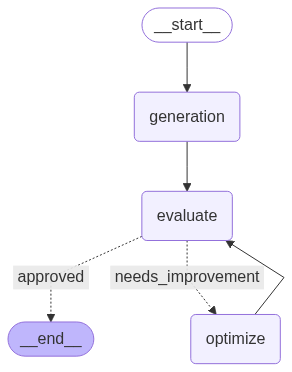

In [49]:
Image(workflow.get_graph().draw_mermaid_png())

In [51]:
output_state=workflow.invoke({'topic':'AI','max_iteration':5,'iteration':0})
output_state

{'topic': 'AI',
 'tweet': 'My boss told me to "leverage AI to increase productivity." So I had it write a professional email explaining that I will be doing absolutely nothing for the next hour. The efficiency is terrifying.',
 'evaluation': 'approved',
 'feedback': 'This tweet is approved. It demonstrates a strong, original voice by taking a tired corporate buzzword ("leverage AI") and subverting it with a relatable, anti-work sentiment. The humor is dry and effective, delivered in a concise, anecdotal format that is perfect for the platform. The final line, "The efficiency is terrifying," is a sharp, memorable punchline that gives the tweet significant viral potential without resorting to a traditional, clunky joke structure. It’s a well-crafted, modern, and highly shareable piece of content.',
 'iteration': 0,
 'max_iteration': 5,
 'tweet_history': ['My boss told me to "leverage AI to increase productivity." So I had it write a professional email explaining that I will be doing abso